In [2]:
# -*- coding: utf-8 -*-
"""
Created on 2021/12/

@author: hu song
"""

# system module
import os, time, random, IPython, glob, sys, copy

# Science Calculate Module
import pandas as pd
import numpy as np

# Data Processing Module 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Module
from sklearn.ensemble import RandomForestRegressor as rfr

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Evaluate Module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import matplotlib # matplotlib.rcParams['font.family'] = "Arial"
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
class cross_val_regressor():
    def __init__(self, model, X, y, random_state, cv):
        super(cross_val_regressor, self).__init__()
        
        if random_state != 0:
            index = np.arange(0,len(y))
            np.random.seed(random_state)
            np.random.shuffle(index)
            np.random.seed(random_state)
            np.random.shuffle(index)
        else:
            index = np.arange(len(y))

        step = int(len(y)/cv)
        self.r2 = []
        self.mse = []
        self.pred_all = np.zeros((len(y)), dtype=float)
        self.obs_all = np.zeros((len(y)), dtype=float)
        for i in range(cv):
            if i < cv-1:
                index_train = np.concatenate([index[:i*step],index[(i+1)*step:]], axis=0)
                index_val = index[i*step:(i+1)*step]
            else: 
                index_train = index[0:i*step]
                index_val = index[i*step:]
        
            X_train = X[index_train]
            y_train = y[index_train]
            X_val = X[index_val]
            y_val = y[index_val]
            
            pred = model.fit(X_train,y_train).predict(X_val)
#             self.pred_all = np.concatenate([self.pred_all,pred], axis=0)
#             print(pred, y_val)
            self.pred_all[index_val] = pred
            self.obs_all[index_val] = y_val
            self.r2.append(r2_score(y_val, pred))
            self.mse.append(MSE(y_val, pred))
            
        self.r2_mean = r2_score(self.obs_all, self.pred_all)
        self.mse_mean = MSE(self.obs_all, self.pred_all)

def result_figure_r(y_test_train, pred_train, y_test_test, pred_test, data_neme, model_name, path):
    # kf_true, kf_pred, test_true, test_pred
    os.makedirs("{}/figure".format(path), exist_ok=True)
    os.makedirs("{}/csv".format(path), exist_ok=True)
    
    r2_train = r2_score(y_test_train, pred_train)
    r2_test = r2_score(y_test_test, pred_test)

    mse_train = MSE(y_test_train, pred_train)
    mse_test = MSE(y_test_test, pred_test)

    mae_train = MAE(y_test_train, pred_train)
    mae_test = MAE(y_test_test, pred_test)
    
    pd.concat([pd.DataFrame(pred_train,columns=["prediction"])
               ,pd.DataFrame(y_test_train,columns=['true'])
               ,pd.DataFrame([r2_train],columns=["r^2"])
               ,pd.DataFrame([np.sqrt(mse_train)],columns=['RMSE'])
               ,pd.DataFrame([mae_train],columns=['MAE'])],axis =1).to_csv("{}/csv/{}_{}_kf.csv".format(path, data_neme, model_name), index=None)
    
    pd.concat([pd.DataFrame(pred_test,columns=["prediction"])
               ,pd.DataFrame(y_test_test,columns=['true'])
               ,pd.DataFrame([r2_test],columns=["r^2"])
               ,pd.DataFrame([np.sqrt(mse_test)],columns=['RMSE'])
               ,pd.DataFrame([mae_test],columns=['MAE'])],axis =1).to_csv("{}/csv/{}_{}_test.csv".format(path, data_neme, model_name), index=None)
    
    plt.figure(figsize=[20,20], dpi=300)
    # plt.grid()
    matplotlib.rcParams['font.family'] = "Arial"
    plt.title('Regressor',fontsize=70
              ,verticalalignment= 'baseline'
              ,horizontalalignment='center')

    xmax = int(max(list(pred_train)+list(y_test_train)+list(pred_test)+list(y_test_test)))+1
    xmin = int(min(list(pred_train)+list(y_test_train)+list(pred_test)+list(y_test_test)))

    plt.scatter(y_test_train, pred_train,c="royalblue", s=200 ,edgecolor="k",alpha=0.7, label="Train Set")
    plt.scatter(y_test_test, pred_test,c="tomato", s=200 ,edgecolor="k",alpha=0.7, label="Test Set")

    line1 = plt.scatter(-2, -2,c="royalblue", s=1200 ,edgecolor="k",alpha=0.9)
    line2 = plt.scatter(-2, -2,c="tomato", s=1200 ,edgecolor="k",alpha=0.9)

    # plt.hexbin(y_test, pred, gridsize=20, bins='log', cmap='Greens', )

    plt.plot(range(xmin,xmax+1),range(xmin,xmax+1),c='k',linewidth=3, linestyle="--", alpha=0.9)
    plt.xlabel('Measured log$_{10}$IBC50',fontsize=50)
    plt.ylabel('Predicted log$_{10}$IBC50',fontsize=50, fontdict={"family":"Arial"})
    labels = [""]+[str(i) for i in range(xmin+1,xmax+1)]
    plt.yticks(ticks=range(xmin,xmax+1), labels=labels, fontsize=40)
    plt.xticks(ticks=range(xmin,xmax+1), labels=range(xmin,xmax+1), fontsize=40)
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.legend(fontsize=50, handles=[line1, line2], labels=['Train Set','Test Set'], framealpha=0)
    plt.savefig("{}/figure/{}_{}.png".format(path, data_neme, model_name))
    plt.show()

    print("R2-5cv = {:.3f} R2-val = {:.3f}".format(r2_train, r2_test))
    print("RMSE-5cv = {:.3f} RMSE-val = {:.3f}".format(np.sqrt(mse_train), np.sqrt(mse_test)))
    print("MAE-5cv = {:.3f} MAE-val = {:.3f}".format(mae_train, mae_test))

def rfr_auto(X, y, test_X, test_y, random_state, cv, data_name, model_name):

    print("*"*100)
    print(data_name, f"Model:{model_name}")
    
    model = rfr(n_jobs=-1)
    before_kf_r2 = cross_val_regressor(model, X, y, random_state, cv).r2_mean
    before_kf_mse = cross_val_regressor(model, X, y, random_state, cv).mse_mean
    
    test_pred = model.fit(X, y).predict(test_X)
    before_test_r2 = r2_score(test_y, test_pred)
    before_test_mse = MSE(test_y, test_pred)
    
    print("before kf r^2", before_kf_r2)
    print("before kf mse", before_kf_mse)
    print("before test r^2", before_test_r2)
    print("before test mse", before_test_mse)
    
    # 随机种子
    scores = []
    for i in range(0,200):
        model = rfr(n_jobs=-1
                    ,random_state=i)
        score = cross_val_regressor(model, X, y, random_state, cv)
        scores.append(score.r2_mean)
        pass
    
    plt.figure()
    plt.plot(range(0,200),scores)
    plt.show()

    random_state_rf = range(0,200)[scores.index(max(scores))]
    print("random_state:", max(scores),random_state_rf)
    
    # 随机树数目
    scores = []
    for i in range(1,200):
        model = rfr(n_estimators=i
                   ,random_state=random_state_rf
                   ,n_jobs=-1)
        score = cross_val_regressor(model, X, y, random_state, cv)
        scores.append(score.r2_mean)
        pass    
    

    plt.figure()
    plt.plot(range(1,200),scores)
    plt.show()

    n_estimators = range(1,200)[scores.index(max(scores))]
    print("n_estimators:", max(scores),n_estimators)
    
    # 最大深度
    scores = []
    for i in range(1,200):
        model = rfr(n_estimators=n_estimators
                   ,random_state=random_state_rf
                   ,n_jobs=-1
                   ,max_depth=i)
        score = cross_val_regressor(model, X, y, random_state, cv)
        scores.append(score.r2_mean)
        pass            

    plt.figure()
    plt.plot(range(1,200),scores)
    plt.show()

    max_depth = range(1,200)[scores.index(max(scores))]
    print("max_depth", max(scores),max_depth)
    
    # 最大特征选择
    scores = []
    for i in range(int(X.shape[1]**0.5),X.shape[1]):
        model = rfr(n_jobs=-1
                   ,n_estimators=n_estimators
                   ,random_state=random_state_rf
                   ,max_depth=max_depth
                   ,max_features=i)
        score = cross_val_regressor(model, X, y, random_state, cv)
        scores.append(score.r2_mean)
        pass

    plt.figure()
    plt.plot(range(int(X.shape[1]**0.5),X.shape[1]),scores)
    plt.show()

    max_features = range(int(X.shape[1]**0.5),X.shape[1])[scores.index(max(scores))]
    print("max_features", max(scores),max_features)
    
    # 最小纯度递减
    scores = []
    for i in np.linspace(0,0.5,20):
        model = rfr(n_jobs=-1
                   ,n_estimators=n_estimators
                   ,random_state=random_state_rf
                   ,max_depth=max_depth
                   ,max_features=max_features
                   ,min_impurity_decrease=i)
        score = cross_val_regressor(model, X, y, random_state, cv)
        scores.append(score.r2_mean)
        pass

    plt.figure()
    plt.plot(np.linspace(0,0.5,20),scores)
    plt.show()

    min_impurity_decrease = np.linspace(0,0.5,20)[scores.index(max(scores))]
    print("min_impurity_decrease:", max(scores),min_impurity_decrease)
    
    # 最大样本数量
    scores = []
    len_train = int(len(y)/cv)*(cv-1)+1
    for i in range(1,len_train):
        model = rfr(n_jobs=-1
                   ,n_estimators=n_estimators
                   ,random_state=random_state_rf
                   ,max_depth=max_depth
                   ,max_features=max_features
                   ,min_impurity_decrease=min_impurity_decrease
                   ,max_samples=i)
        score = cross_val_regressor(model, X, y, random_state, cv)
        scores.append(score.r2_mean)
        pass

    plt.figure()
    plt.plot(range(1,len_train),scores)
    plt.show()
    
    model = rfr(n_jobs=-1
           ,n_estimators=n_estimators
           ,random_state=random_state_rf
           ,max_depth=max_depth
           ,max_features=max_features
           ,min_impurity_decrease=min_impurity_decrease
           ,max_samples=None)
    if cross_val_regressor(model, X, y, random_state, cv).r2_mean > max(scores):
        max_samples  = None
    else:
        max_samples = range(1,len_train)[scores.index(max(scores))]
    print("max samples", max(scores),max_samples)
#     max_samples  = None
    ####################################

    model = rfr(n_jobs=-1
               ,n_estimators=n_estimators
               ,random_state=random_state_rf
               ,max_depth=max_depth
               ,max_features=max_features
               ,min_impurity_decrease=min_impurity_decrease
               ,max_samples=max_samples)
    score = cross_val_regressor(model, X, y, random_state, cv)
    after_kf_r2 = score.r2_mean
    after_kf_mse = score.mse_mean
    
    if max_samples != None:
        # 重新根据max_sample的大小范围等比例放缩
        max_samples = int(max_samples/(len_train-1)*len(test_y))
#     max_samples= 1037
    model = rfr(n_jobs=-1
               ,n_estimators=n_estimators
               ,random_state=random_state_rf
               ,max_depth=max_depth
               ,max_features=max_features
               ,min_impurity_decrease=min_impurity_decrease
               ,max_samples=max_samples)
    test_pred = model.fit(X, y).predict(test_X)
    after_test_r2 = r2_score(test_y, test_pred)
    after_test_mse = MSE(test_y, test_pred)
    
    print("kf r^2:", before_kf_r2, "->", after_kf_r2)
    print("kf MSE:", before_kf_mse, "->", after_kf_mse)
    
    print("test r^2:", before_test_r2, "->", after_test_r2)
    print("test MSE:", before_test_mse, "->", after_test_mse)

    
    print("n_estimators=",n_estimators,","
          , "random_state=",random_state_rf,","
          , "max_depth=",max_depth,","
          , "max_features=",max_features,","
          , "min_impurity_decrease=",min_impurity_decrease,","
          , "max_samples=",max_samples)
    
    os.makedirs("./model", exist_ok = True)
    pd.DataFrame([n_estimators
                  , random_state_rf
                  , max_depth
                  , max_features
                  , min_impurity_decrease
                  , max_samples]).to_csv("./model/parma_{}_{}.csv".format(data_name, model_name),index=0)

    result_figure_r(y, score.pred_all, test_y, test_pred, data_name, model_name, "./results")
    return model, score.pred_all, test_pred

import warnings
warnings.filterwarnings("ignore")

def show_importance(importances, features, len_imp=20, save_path=False, title=None):
    '''
    importances: list of importance
    features: list of feature
    len_imp: Num of top importance
    save_path: if false, don't save, else save at save_path
    '''
    importances_top = np.sort(importances)[::-1][:len_imp]
    importances_top_index = np.argsort(importances)[::-1][:len_imp]
    matplotlib.rcParams['font.family'] = "Arial"
    plt.figure(figsize=[16,9], dpi=300)
    plt.title("Top %d Importances of %s"%(len_imp, title), fontsize=30)
    plt.bar(range(len_imp), importances_top, color='silver')
    plt.xticks(range(len_imp), features[importances_top_index], rotation=60, fontsize=15)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(save_path+'/importance_%s.png'%title)
        pd.DataFrame([features, importances
                      , features[np.argsort(importances)[::-1]]
                      , np.sort(importances)[::-1]], index=['Original order', 'Importances', 'Sort order', 'Importances']).T.to_csv(save_path+'/importance_%s.csv'%title, index=None)
    plt.show()

In [4]:
data = pd.read_csv('./des_all.csv')
y_GES_1 = np.array(data.iloc[:,1].to_list())
y_FHC = np.array(data.iloc[:,2].to_list())
x = data.iloc[:,4:]
columns = x.columns
x = StandardScaler().fit_transform(x)

****************************************************************************************************
y_c7 Model:RFC
before kf r^2 0.6516242935145911
before kf mse 3680.6111125
before test r^2 0.9333554687915949
before test mse 704.1036375000002


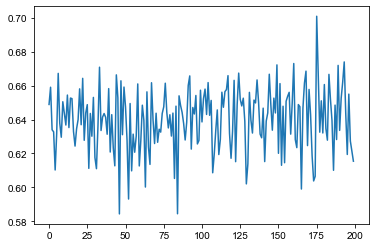

random_state: 0.7009591619784549 175


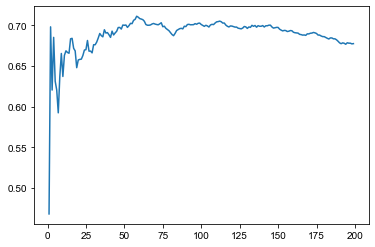

n_estimators: 0.711111382395033 58


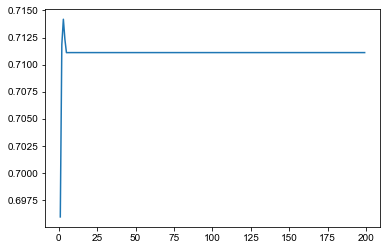

max_depth 0.7141918609958348 3


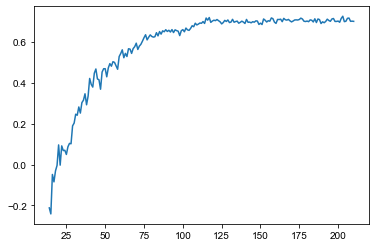

max_features 0.7249767215754381 203


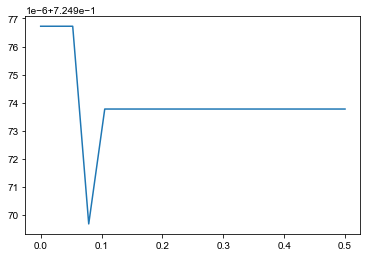

min_impurity_decrease: 0.7249767215754384 0.02631578947368421


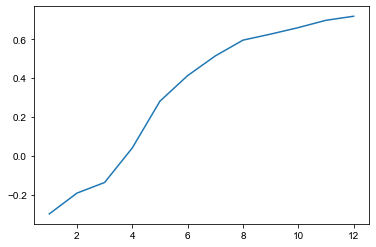

max samples 0.7175837231089686 None
kf r^2: 0.6516242935145911 -> 0.724976721575438
kf MSE: 3680.6111125 -> 2905.638125510399
test r^2: 0.9333554687915949 -> 0.9309618224411327
test MSE: 704.1036375000002 -> 729.3926607955308
n_estimators= 58 , random_state= 175 , max_depth= 3 , max_features= 203 , min_impurity_decrease= 0.02631578947368421 , max_samples= None


In [142]:
# FHC随机分林回归调参,用原X，y代替没有进行试验的测试集，预测得到的test分数和预测值无意义，仅采用五折的结果即可
rfr_c7, y_rfr_train_pred, y_rfr_test_pred= rfr_auto(x, y_FHC, x, y_FHC, 1, 5, 'y_c7', "RFC")

****************************************************************************************************
GES_1 Model:RFC
before kf r^2 0.44445586206135346
before kf mse 6881.314737499999
before test r^2 0.9348777886927522
before test mse 806.6441562500002


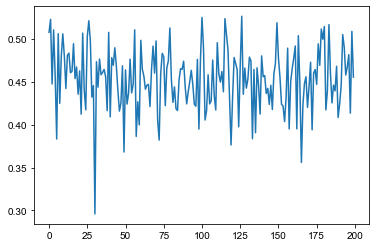

random_state: 0.5264778092542515 126


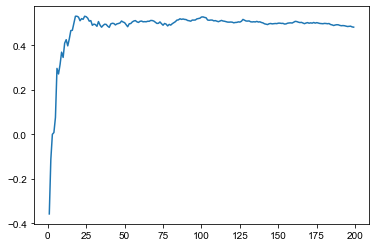

n_estimators: 0.5299485874919299 24


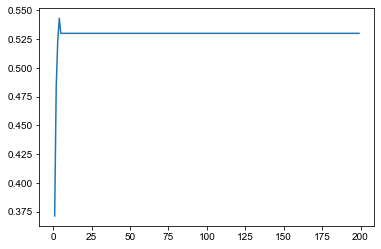

max_depth 0.5430767747369831 4


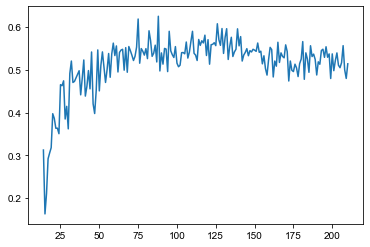

max_features 0.6254886453994998 88


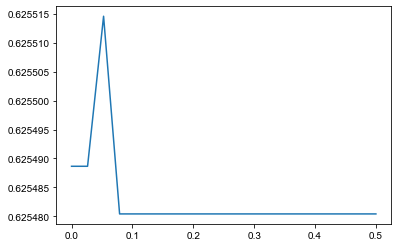

min_impurity_decrease: 0.6255145990751958 0.05263157894736842


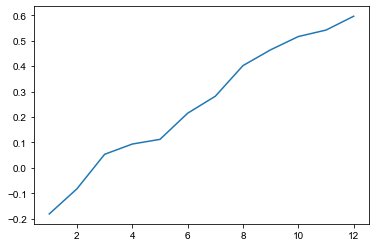

max samples 0.5960428817338088 None
kf r^2: 0.44445586206135346 -> 0.6255145990751958
kf MSE: 6881.314737499999 -> 4638.608766396605
test r^2: 0.9348777886927522 -> 0.9129437968008958
test MSE: 806.6441562500002 -> 1078.332202887811
n_estimators= 24 , random_state= 126 , max_depth= 4 , max_features= 88 , min_impurity_decrease= 0.05263157894736842 , max_samples= None


In [144]:
# GES_1随机分林回归调参，用原X，y代替没有进行试验的测试集，预测得到的test分数和预测值无意义，仅采用五折的结果即可
rfr_GES_1, GES_1_train_pred, GES_1_test_pred = rfr_auto(x, y_GES_1, x, y_GES_1, 1, 5, 'GES_1', "RFC")

Index(['p_DLS_ave', 's_DLS_ave', 'core', 'BCUT_PEOE_2', 'a_ICM', 's_Zeta_ave',
       'PEOE_VSA_FPNEG', 'h_pKb', 'PEOE_RPC-', 'PEOE_VSA_FPOL'],
      dtype='object')
Index(['s_DLS_ave', 'core', 'p_DLS_ave', 'BCUT_PEOE_2', 'VAdjEq',
       'BCUT_SLOGP_3', 'PEOE_RPC-', 'GCUT_SLOGP_3', 'PEOE_RPC+', 's_Zeta_ave'],
      dtype='object')


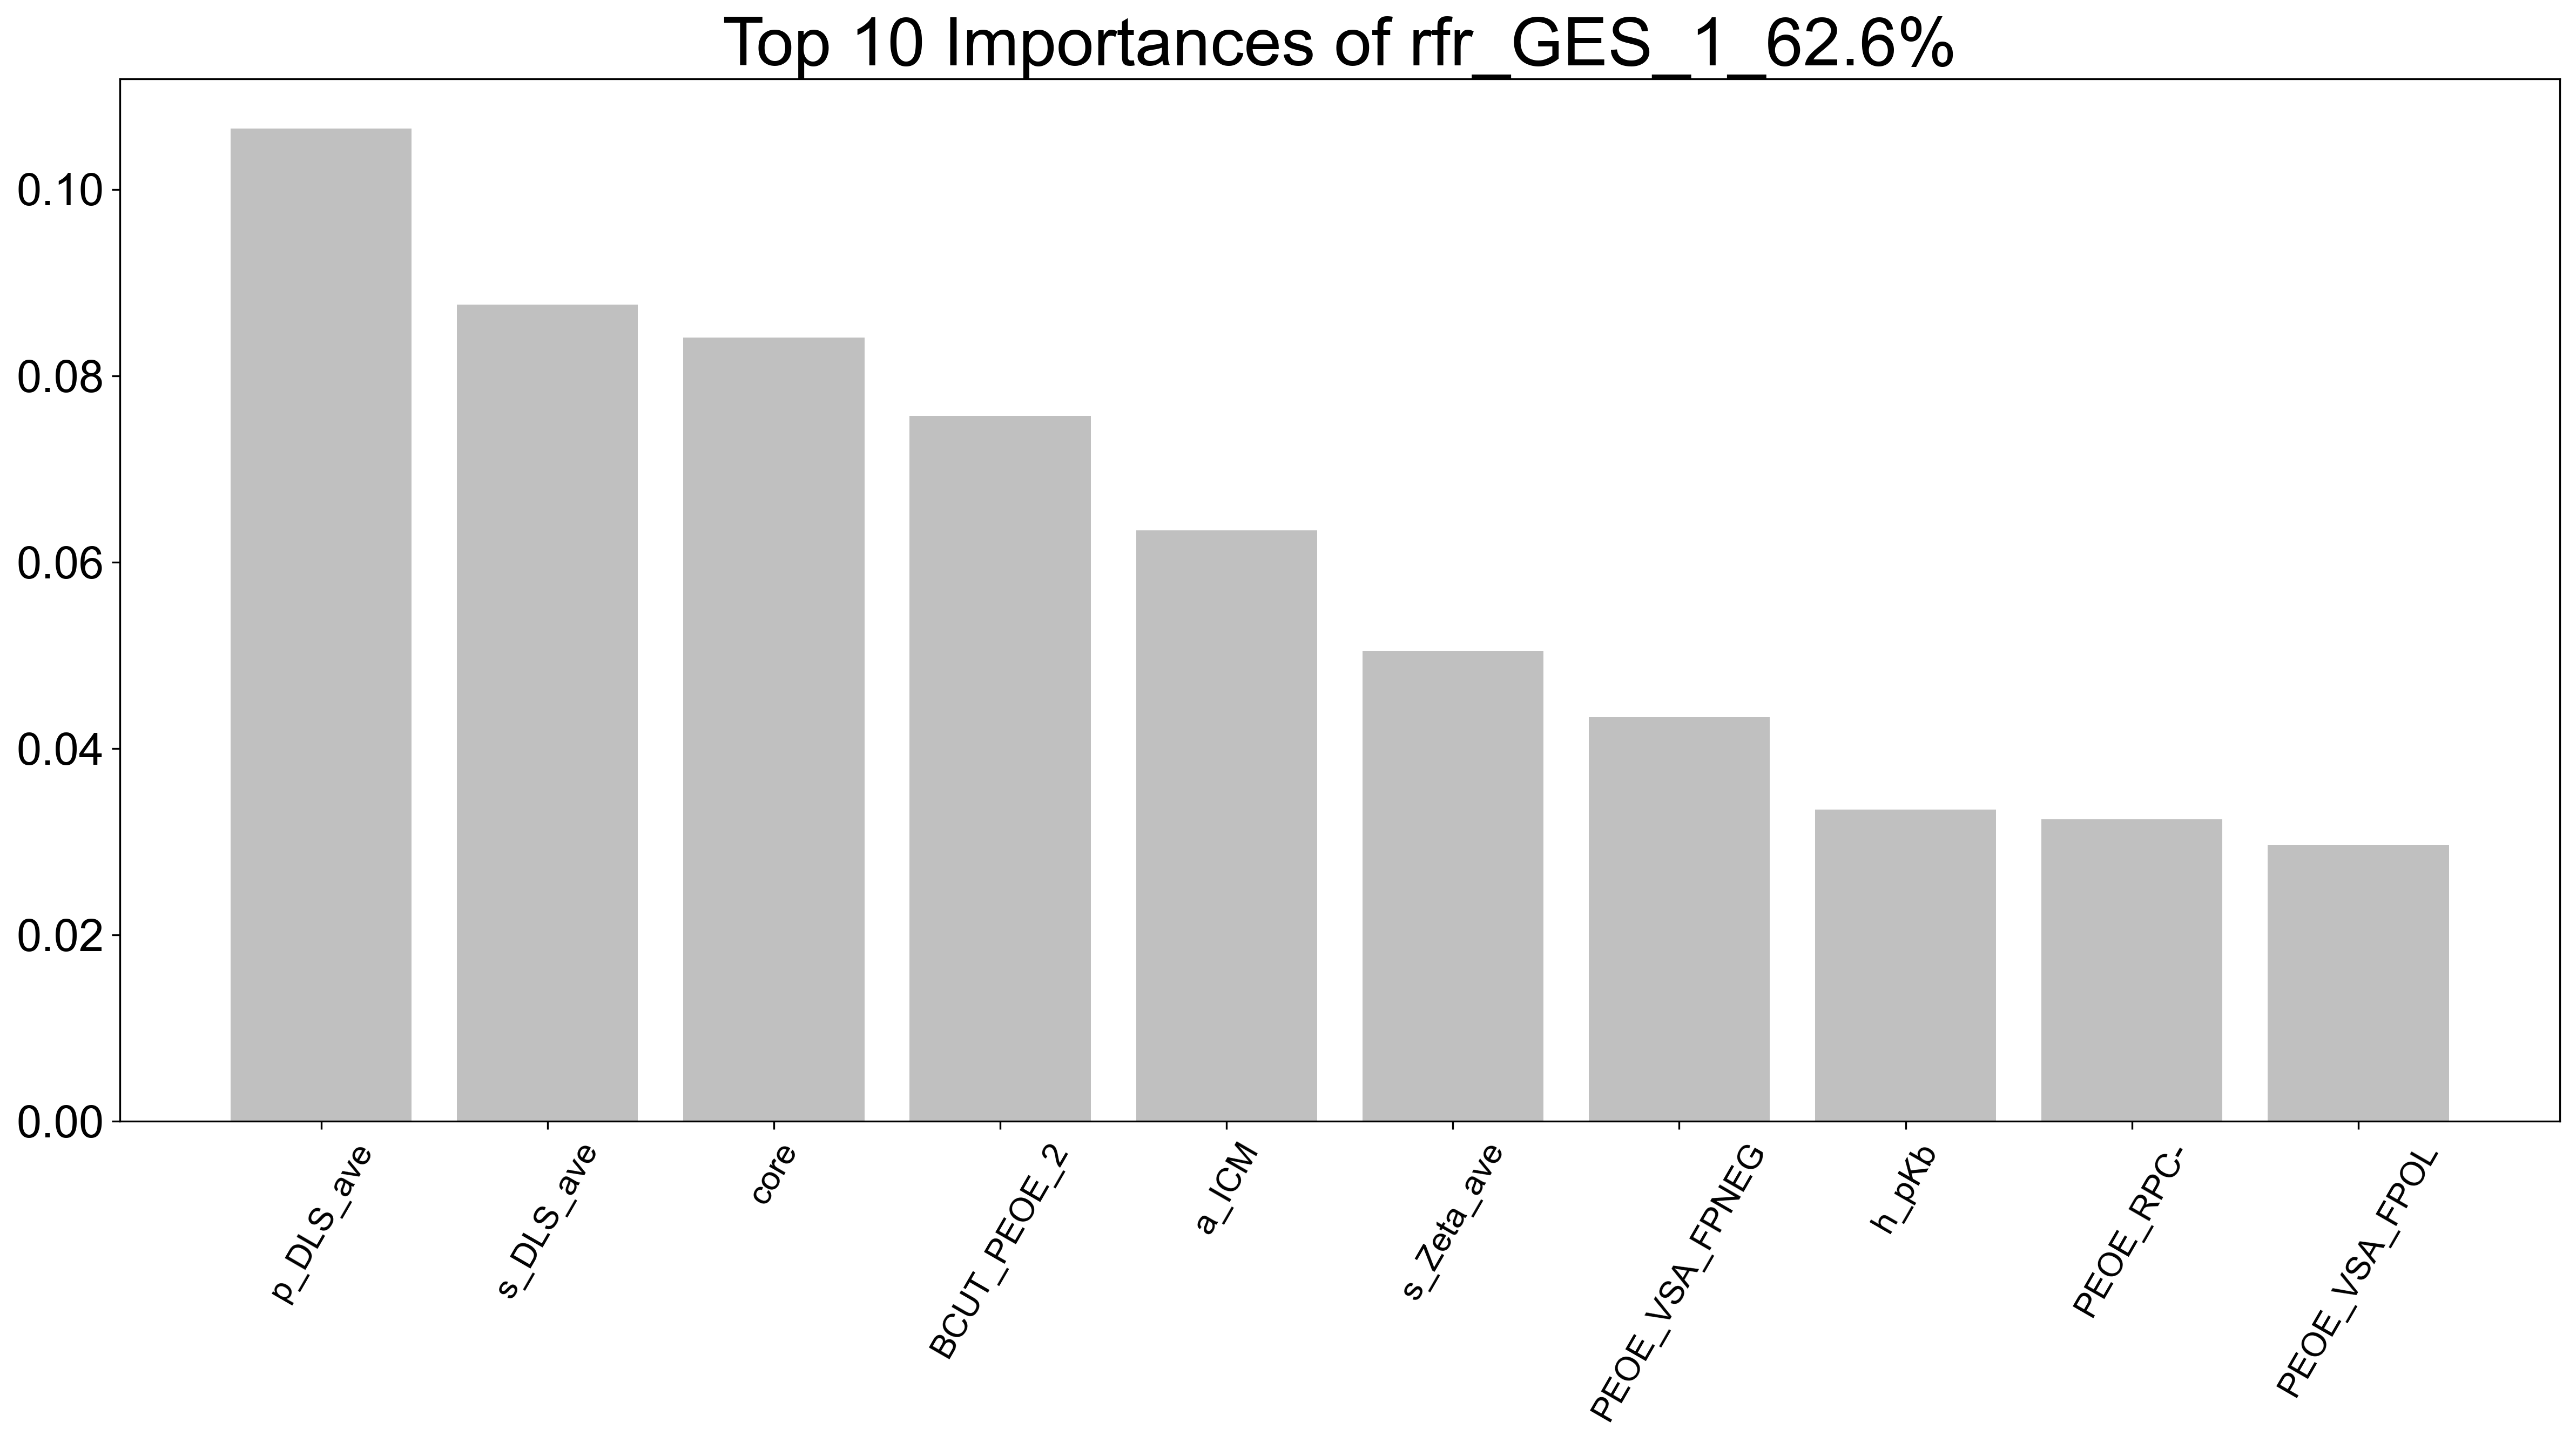

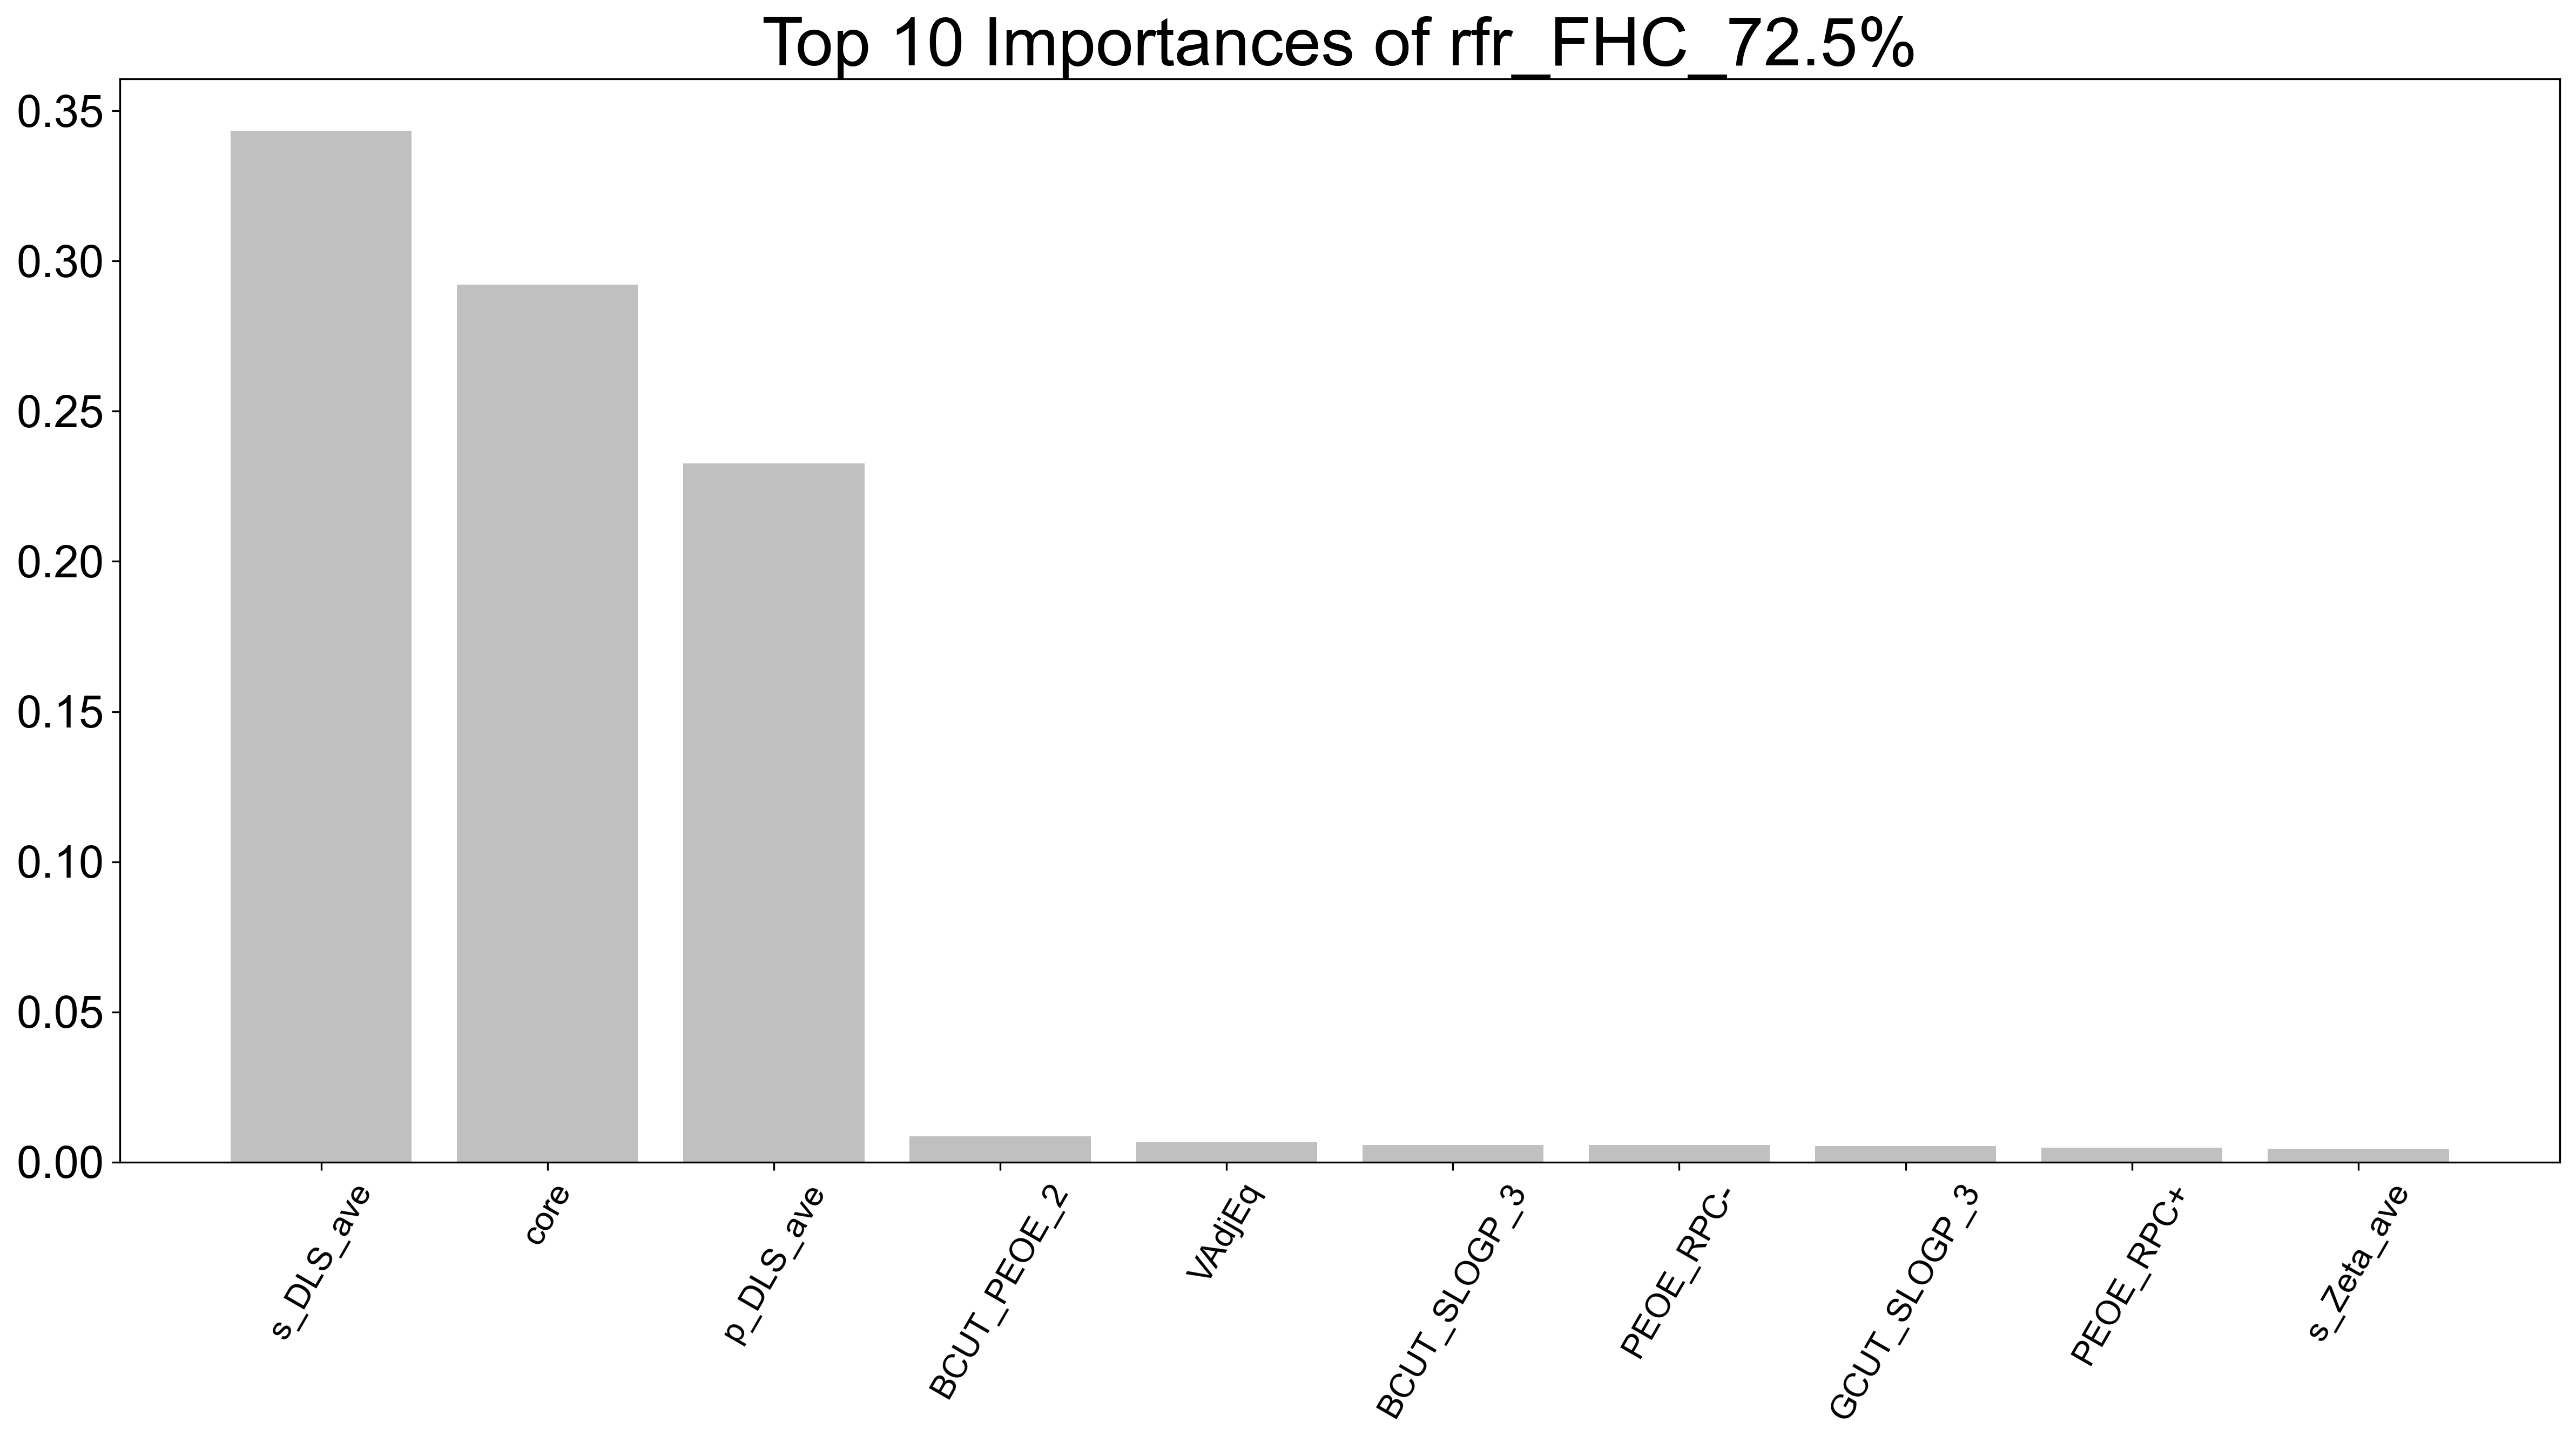

In [155]:
# 重要性分析
index_GES_1 = np.argsort(rfr_GES_1.fit(x, y_GES_1).feature_importances_)[::-1]
index_FHC = np.argsort(rfr_c7.fit(x, y_FHC).feature_importances_)[::-1]

print(columns[index_GES_1[:10]])
print(columns[index_FHC[:10]])

show_importance(rfr_GES_1.fit(x, y_GES_1).feature_importances_, columns, len_imp=10, title="rfr_GES_1_62.6%", save_path="./importance/")
show_importance(rfr_c7.fit(x, y_FHC).feature_importances_, columns, len_imp=10, title="rfr_FHC_72.5%", save_path="./importance/")